# Clustering particles

In [1]:
# Libraries ----
import sys  # type: ignore
import imageio  # type: ignore
import warnings
import numpy as np  # type: ignore
import pandas as pd  # type: ignore

from tqdm import tqdm  # type: ignore

sys.path.append('../modules')
import track_particles as tp  # type: ignore
import plot_tracking as plt_tp  # type: ignore
import plot_clustering as plt_cp  # type: ignore
import clustering_particles as cp  # type: ignore

# Global options ----
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)

## Global variables

In [2]:
input_path = "../input_files"
output_path = "../output_files"
log_path = "../logs"
input_generation_date = "2025-02-18"

video_name = "3n_0m_3f_240215_1"
n_particles = int(video_name[0])
save_figures = True
save_tracking = True
x_bounds = [0, 1080]
y_bounds = [60, 1860]
x_zoom = [0, 1080]
y_zoom = [0, 1920]

## Setting video information

In [3]:
# Load the video
reader = imageio.get_reader("{}/{}.mp4".format(input_path, video_name), "ffmpeg")

# Check the number of frames
num_frames = reader.count_frames()
print("Total frames: {}".format(num_frames))

# Extract a frame to inspect the content
time = 0
frame = reader.get_data(time)
print("Frames resolution: {} x {}".format(frame.shape[0], frame.shape[1]))

Total frames: 144227
Frames resolution: 1080 x 1920


In [5]:
df_tracked = pd.concat([
    pd.read_csv("{}/tracked_{}_0.csv".format(output_path, video_name), low_memory=False),
    pd.read_csv("{}/tracked_{}_1.csv".format(output_path, video_name), low_memory=False),
    pd.read_csv("{}/tracked_{}_2.csv".format(output_path, video_name), low_memory=False),
    pd.read_csv("{}/tracked_{}_3.csv".format(output_path, video_name), low_memory=False),
    pd.read_csv("{}/tracked_{}_4.csv".format(output_path, video_name), low_memory=False)#,
    # pd.read_csv("{}/tracked_{}_5.csv".format(output_path, video_name), low_memory=False),
    # pd.read_csv("{}/tracked_{}_6.csv".format(output_path, video_name), low_memory=False),
    #pd.read_csv("{}/tracked_{}_7.csv".format(output_path, video_name), low_memory=False),
    # pd.read_csv("{}/tracked_{}_8.csv".format(output_path, video_name), low_memory=False)
]).sort_values(["id", "time"])

In [6]:
if "coords_x" in df_tracked.columns:
    df_tracked["coords_x"] = df_tracked["coords_x"].apply(lambda x: np.fromstring(x, sep=" "))
    df_tracked["coords_y"] = df_tracked["coords_y"].apply(lambda x: np.fromstring(x, sep=" "))
df_tracked.sort_values(["time", "id"]).head(2 * n_particles)

,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count
0,0,0,1286.168608,8.472405,1285.870551,8.485711,0.0,1312.000000,0.000000,0.584314,1214.000000,0.000000,1.548553,1975.0,147.128495,23.065516,0.987635,5
1,1,0,1546.014837,24.566766,1545.805856,24.593140,NaN,1546.014837,24.566766,NaN,1546.014837,24.566766,-1.407791,1348.0,135.690781,35.995501,0.964173,5
2,2,0,326.092756,123.850523,340.225584,123.291935,NaN,326.092756,123.850523,NaN,326.092756,123.850523,-1.545791,13293.0,251.089289,113.262957,0.892480,5
3,3,0,846.551843,134.850481,841.814015,134.090768,0.0,753.000000,74.000000,0.623529,846.000000,150.000000,1.453585,17476.0,239.946347,112.797412,0.882616,5
4,4,0,168.210221,212.811438,168.661619,212.868119,NaN,168.210221,212.811438,NaN,168.210221,212.811438,0.997497,7064.0,157.866614,90.080912,0.821218,5
5,0,3,1547.457903,24.297637,1547.275164,24.311386,NaN,1547.457903,24.297637,NaN,1547.457903,24.297637,-1.399323,1354.0,127.513892,36.432685,0.958315,5


In [7]:
# Manual Setup for time = 0
tracking_0 = df_tracked[df_tracked["time"] == 0]
cols = ["id", "time", "id_count", "position_x", "position_y", "orientation"]
print("Initial tracking at time 0:\n", tracking_0[cols])

if tracking_0.shape[0] != n_particles:
    # Manual fitting of initial time tracking
    tracking_0 = tracking_0.drop_duplicates(subset=["id"], keep="first")
    tracking_0 = tracking_0[tracking_0["id"].isin([2, 3, 4])]
    tracking_0["id"] = np.arange(n_particles)
    tracking_0["orientation"] = np.array([
        -tracking_0["orientation"].values[0],
        -tracking_0["orientation"].values[1],
        -tracking_0["orientation"].values[1]
    ])

    # Replace the manual setting
    df_tracked = pd.concat([
        tracking_0,
        df_tracked[df_tracked["time"] != 0]
    ]).sort_values(["id", "time"])

df_tracked.sort_values(["time", "id"]).head(2 * n_particles + 1)

Initial tracking at time 0:
    id  time  id_count   position_x  position_y  orientation
0   0     0         5  1286.168608    8.472405     1.548553
1   1     0         5  1546.014837   24.566766    -1.407791
2   2     0         5   326.092756  123.850523    -1.545791
3   3     0         5   846.551843  134.850481     1.453585
4   4     0         5   168.210221  212.811438     0.997497


,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count
2,0,0,326.092756,123.850523,340.225584,123.291935,NaN,326.092756,123.850523,NaN,326.092756,123.850523,1.545791,13293.0,251.089289,113.262957,0.892480,5
3,1,0,846.551843,134.850481,841.814015,134.090768,0.0,753.000000,74.000000,0.623529,846.000000,150.000000,-1.453585,17476.0,239.946347,112.797412,0.882616,5
4,2,0,168.210221,212.811438,168.661619,212.868119,NaN,168.210221,212.811438,NaN,168.210221,212.811438,-1.453585,7064.0,157.866614,90.080912,0.821218,5
5,0,3,1547.457903,24.297637,1547.275164,24.311386,NaN,1547.457903,24.297637,NaN,1547.457903,24.297637,-1.399323,1354.0,127.513892,36.432685,0.958315,5
6,1,3,325.919784,123.739374,339.835519,123.049245,NaN,325.919784,123.739374,NaN,325.919784,123.739374,-1.545049,13364.0,250.160340,113.887655,0.890359,5
7,2,3,846.362565,135.115923,841.538339,134.571516,0.0,753.000000,74.000000,0.623529,833.000000,150.000000,1.456651,17572.0,239.587156,113.779838,0.880040,5
8,3,3,71.146245,164.830040,71.421274,166.880387,NaN,71.146245,164.830040,NaN,71.146245,164.830040,0.272207,253.0,158.003779,79.173258,0.865398,5


In [8]:
df_tracked.sort_values(["time", "id"]).tail(5)

,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count
32747,3,144222,1571.868829,1063.779384,1571.078410,1063.860804,NaN,1571.868829,1063.779384,NaN,1571.868829,1063.779384,-1.521364,4841.0,208.756387,43.848400,0.977692,4
32748,0,144225,387.507886,22.595658,389.735653,23.748602,0.0,325.000000,0.000000,0.560784,325.000000,1.000000,-1.540704,5389.0,129.689538,57.870483,0.894922,4
32749,1,144225,1623.923464,108.714696,1620.010799,108.825148,0.0,1652.000000,40.000000,0.384314,1625.000000,148.000000,-1.268241,8349.0,185.452446,109.859034,0.805656,4
32750,2,144225,392.257978,193.022226,397.382741,200.247868,NaN,392.257978,193.022226,NaN,392.257978,193.022226,0.285711,16827.0,251.059097,112.821575,0.893339,4
32751,3,144225,1571.823907,1063.740211,1571.042662,1063.820240,NaN,1571.823907,1063.740211,NaN,1571.823907,1063.740211,-1.521669,4827.0,208.196147,43.910379,0.977506,4


## Velocities distribution in each frame

In [9]:
omega_threshold = np.pi / 2 # Angular velocity per frame
velocity_threshold = 94.0 # Velocity per frame limited with half average size of particle
print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi)

# Compute differences for each id
df_tracked["delta_time"] = df_tracked.groupby(["id"])["time"].diff()
df_tracked["velocity_x"] = df_tracked.groupby(["id"])["position_x"].diff()
df_tracked["velocity_y"] = df_tracked.groupby(["id"])["position_y"].diff()
df_tracked["velocity_orientation"] = df_tracked.groupby(["id"])["orientation"].diff()

# Compute velocity components (change in position divided by change in time)
df_tracked["velocity_x"] = df_tracked["velocity_x"] / df_tracked["delta_time"]
df_tracked["velocity_y"] = df_tracked["velocity_y"] / df_tracked["delta_time"]
df_tracked["velocity_orientation"] = df_tracked["velocity_orientation"] / df_tracked["delta_time"]

# Filter short jumps (highest velocities are False)
df_tracked["mask_x"] = np.where(np.abs(df_tracked["velocity_x"]) <= velocity_threshold, True, False)
df_tracked["mask_y"] = np.where(np.abs(df_tracked["velocity_y"]) <= velocity_threshold, True, False)
df_tracked["mask_orientation"] = np.where(np.abs(df_tracked["velocity_orientation"]) <= omega_threshold, True, False)


Thresholds:
	- Velocity: 94.0 
	- Angle: 90.0


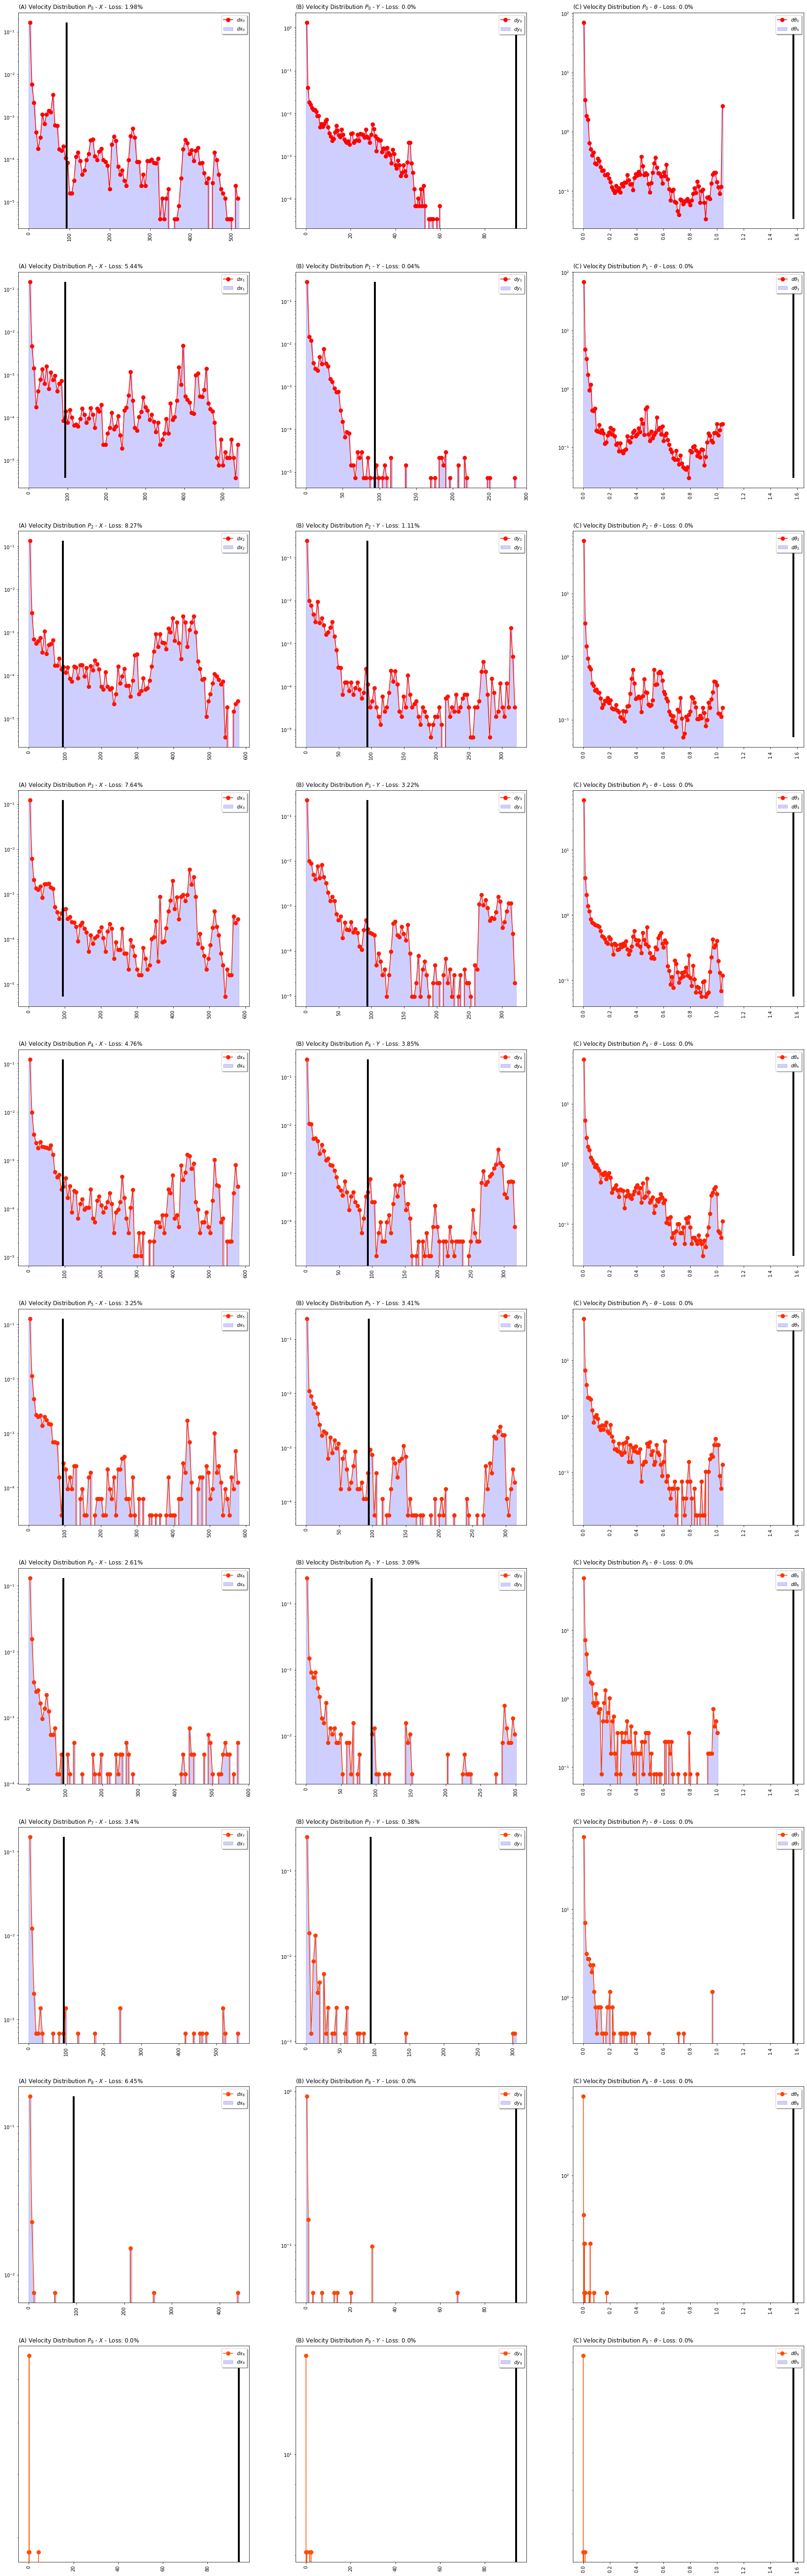

In [10]:
bins = 100
width = 10
fancy_legend = True

plt_cp.plot_velocities_distribution(
    df_tracked=df_tracked,
    bins=bins,
    velocity_threshold=velocity_threshold,
    omega_threshold=omega_threshold,
    width=width,
    fancy_legend=fancy_legend
)

In [11]:
df_tracked[["id_count"]].value_counts(dropna=False, sort=False, normalize=False).reset_index().sort_values("id_count")

,id_count,count
0,2,1734
1,3,45144
2,4,64004
3,5,53223
4,6,25506
5,7,6993
6,8,1872
7,9,216
8,10,70


## Clustering frames

In [12]:
# id_count = df_tracked["id_count"].max()
type = "local equalized"
clip_limit = 0.05
omega_threshold = df_tracked["velocity_orientation"].abs().quantile(0.965) # Angular velocity per frame
velocity_threshold = 100 # Velocity per frame limited with half average size of particle
compare_bounds = False
similarity_threshold = 0.85

print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")
# ids = df_tracked[df_tracked["id_count"] != n_particles]["id_count"].unique()
# ids = sorted(np.sort(ids), key=lambda n: abs(n - n_particles))

df_clustered = cp.clustering_local_frames(
    reader=reader,
    df_tracked=df_tracked,
    weights_previous_time=[0],
    type=type,
    clip_limit=clip_limit,
    distance_threshold=velocity_threshold,
    compare_bounds=compare_bounds,
    similarity_threshold=similarity_threshold,
    n_particles=n_particles
)

Thresholds:
	- Velocity: 100 
	- Angle: 49.02158440185985 



In [13]:
df_clustered["id_count_new"] = df_clustered.groupby(["time"])["id"].transform("count")  # noqa: 501

### Explore final data

In [14]:
df_counts = (
    df_tracked[["id_count", "mask_x", "mask_y", "mask_orientation"]]
    .value_counts(dropna=False, sort=False, normalize=True)
    .reset_index()
    .sort_values(["id_count", "mask_x", "mask_y", "mask_orientation"])
)
df_counts["proportion"] = 100 * df_counts["proportion"]
df_counts

,id_count,mask_x,mask_y,mask_orientation,proportion
0,2,False,False,False,0.866363
1,2,True,False,False,0.006037
2,3,False,False,False,21.531279
3,3,False,True,False,0.140369
4,3,True,False,False,0.948874
5,3,True,True,False,0.092070
6,4,False,False,False,30.071643
7,4,False,True,False,0.373814
8,4,True,False,False,1.631600
9,4,True,True,False,0.124269


In [15]:
omega_threshold = df_tracked["velocity_orientation"].abs().quantile(0.965) # Angular velocity per frame
velocity_threshold = df_tracked["velocity_x"].abs().quantile(0.815) # Velocity per frame limited with half average size of particle
print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")

# Compute differences for each id
df_clustered["delta_time"] = df_clustered.groupby(["id"])["time"].diff()
df_clustered["velocity_x"] = df_clustered.groupby(["id"])["position_x"].diff()
df_clustered["velocity_y"] = df_clustered.groupby(["id"])["position_y"].diff()
df_clustered["velocity_orientation"] = df_clustered.groupby(["id"])["orientation"].diff()

# Compute velocity components (change in position divided by change in time)
df_clustered["velocity_x"] = df_clustered["velocity_x"] / df_clustered["delta_time"]
df_clustered["velocity_y"] = df_clustered["velocity_y"] / df_clustered["delta_time"]
df_clustered["velocity_orientation"] = df_clustered["velocity_orientation"] / df_clustered["delta_time"]

# Filter short jumps (highest velocities are False)
df_clustered["mask_x"] = np.where(np.abs(df_clustered["velocity_x"]) <= velocity_threshold, True, False)
df_clustered["mask_y"] = np.where(np.abs(df_clustered["velocity_y"]) <= velocity_threshold, True, False)
df_clustered["mask_orientation"] = np.where(np.abs(df_clustered["velocity_orientation"]) <= omega_threshold, True, False)


Thresholds:
	- Velocity: 10.305241212161384 
	- Angle: 49.02158440185985 



In [16]:
df_counts = (
    df_clustered[["id_count_new", "mask_x", "mask_y", "mask_orientation"]]
    .value_counts(dropna=False, sort=False, normalize=True)
    .reset_index()
    .sort_values(["id_count_new", "mask_x", "mask_y", "mask_orientation"])
)
df_counts["proportion"] = 100 * df_counts["proportion"]

print("Final loss data : {}%".format(df_counts[df_counts["id_count_new"]!=n_particles]["proportion"].sum()))
print("Final loss data X-axis: {}%".format(df_counts[df_counts["mask_x"]==False]["proportion"].sum()))
print("Final loss data Y-axis: {}%".format(df_counts[df_counts["mask_y"]==False]["proportion"].sum()))
print("Final loss data Angle : {}%".format(df_counts[df_counts["mask_orientation"]==False]["proportion"].sum()))
df_counts

Final loss data : 0.4353393085787452%
Final loss data X-axis: 4.866249091601204%
Final loss data Y-axis: 3.1311208775997508%
Final loss data Angle : 2.010589334532997%


,id_count_new,mask_x,mask_y,mask_orientation,proportion
0,1,False,False,False,0.000692
1,1,True,True,True,0.000692
2,2,False,False,True,0.000692
3,2,True,True,True,0.003461
4,3,False,False,False,0.139115
5,3,False,False,True,2.080493
6,3,False,True,False,0.448489
7,3,False,True,True,2.140015
8,3,True,False,False,0.048448
9,3,True,False,True,0.813925


In [17]:
df_filter_clustered = df_clustered[df_clustered["id_count_new"] == n_particles]
df_filter_clustered["id_count"] = df_filter_clustered["id_count_new"]
df_filter_clustered = df_filter_clustered.drop(columns=["id_count_new"])

Thresholds:
	- Velocity: 10.305241212161384 
	- Angle: 49.02158440185985 



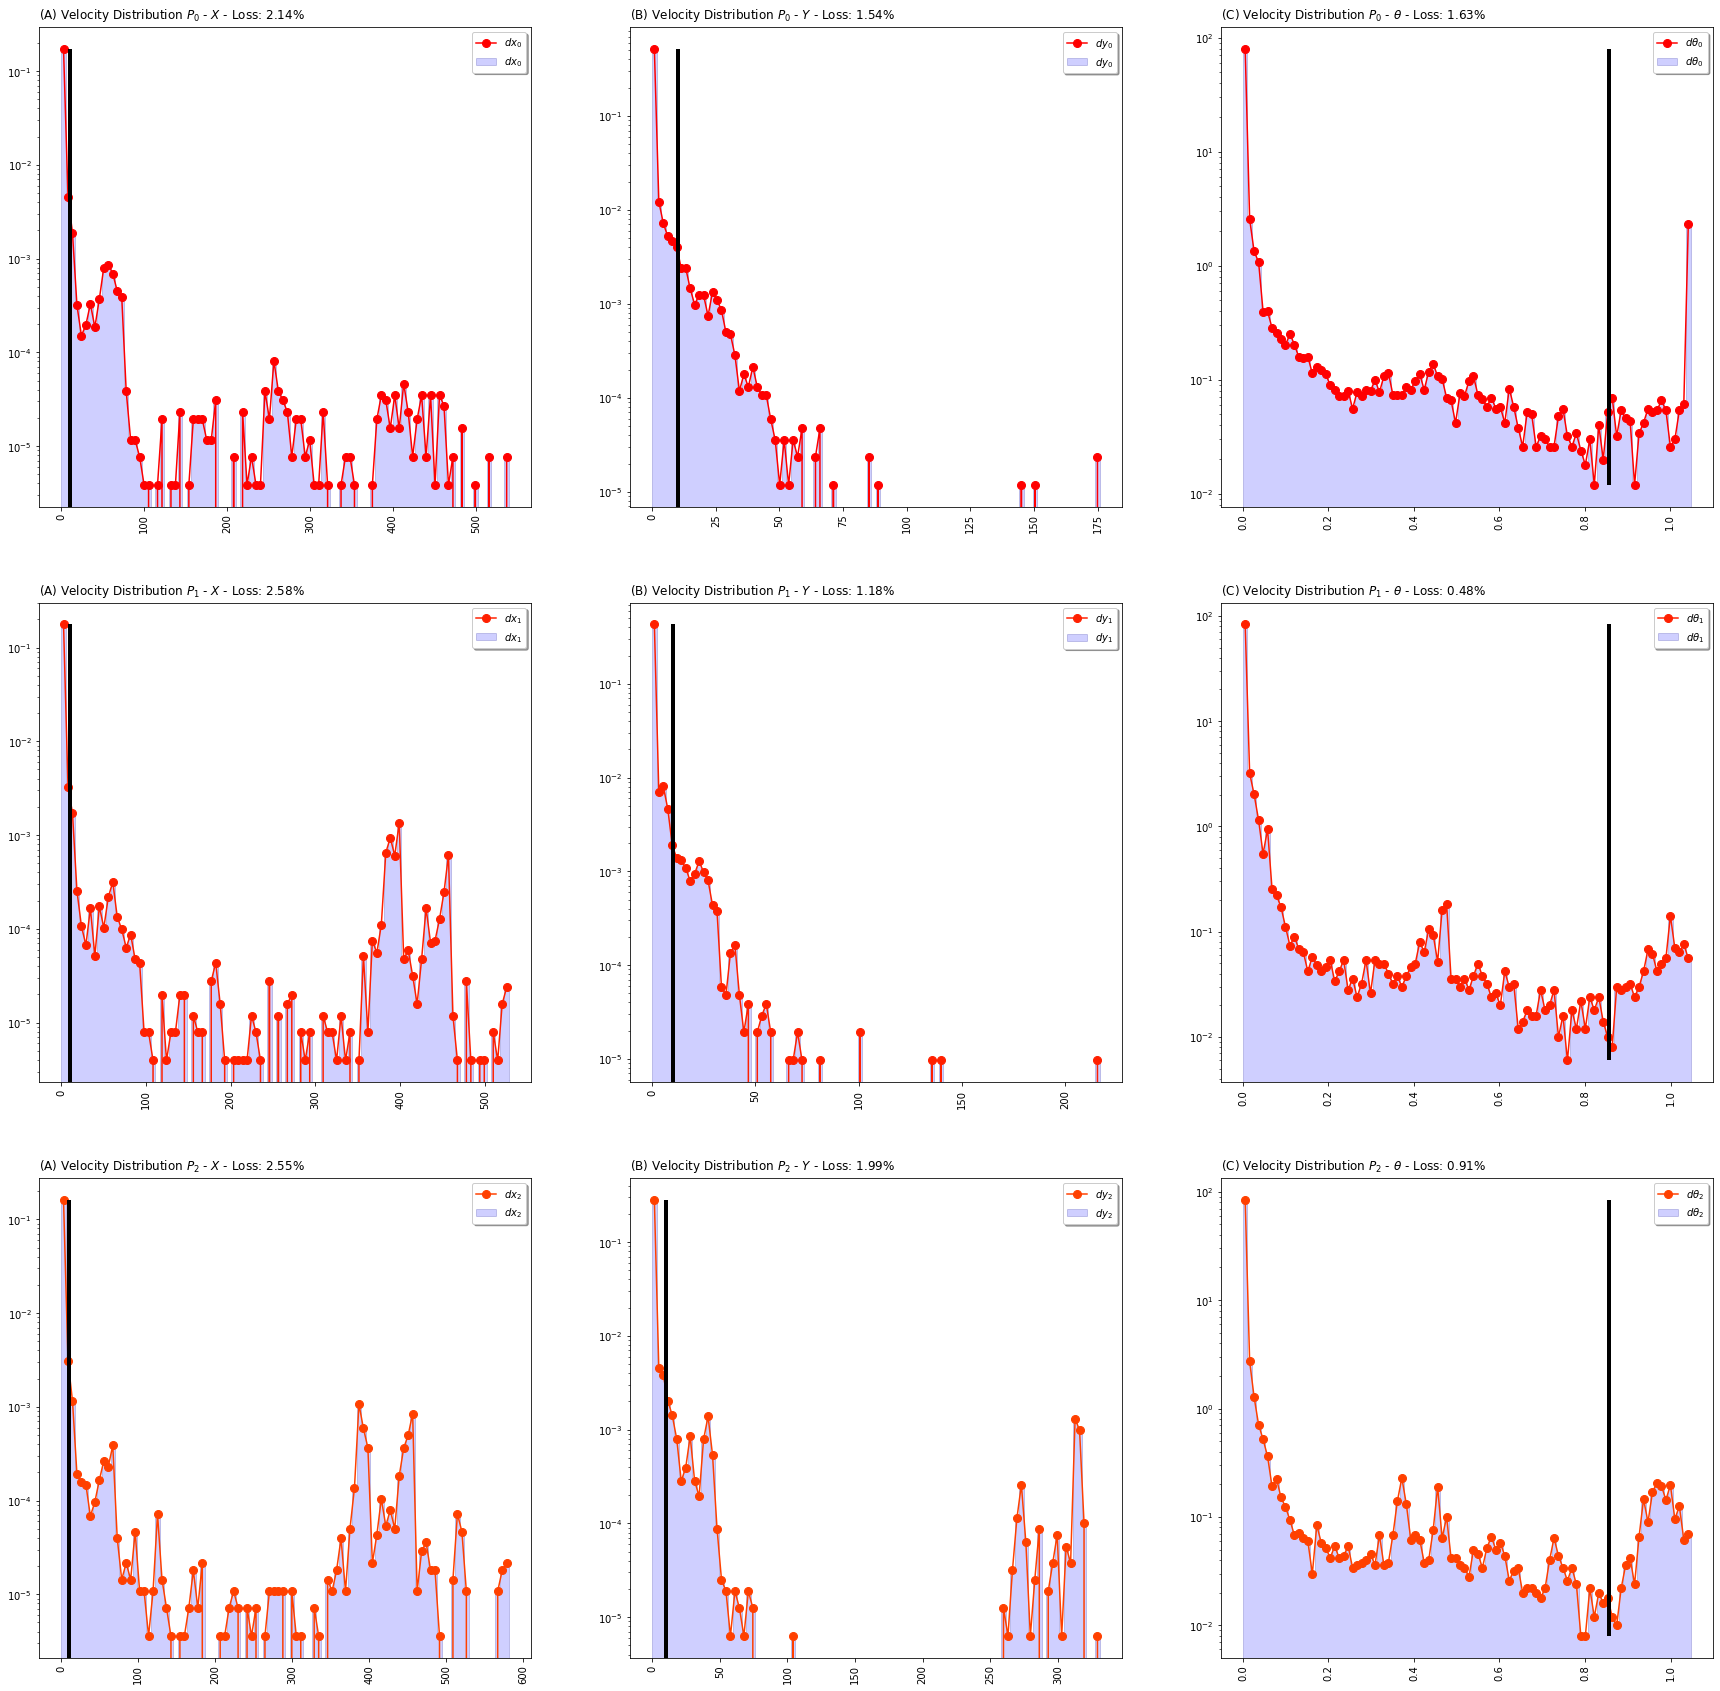

In [18]:
bins = 100
width = 10
fancy_legend = True
omega_threshold = df_tracked["velocity_orientation"].abs().quantile(0.965) # Angular velocity per frame
velocity_threshold = df_tracked["velocity_x"].abs().quantile(0.815) # Velocity per frame limited with half average size of particle
print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")

plt_cp.plot_velocities_distribution(
    df_tracked=df_filter_clustered,
    bins=bins,
    velocity_threshold=velocity_threshold,
    omega_threshold=omega_threshold,
    width=width,
    fancy_legend=fancy_legend
)

In [19]:
if "coords_x" in df_filter_clustered.columns:
    df_filter_clustered.drop(columns=["coords_x", "coords_y"]).to_csv("{}/clustered_{}.csv".format(output_path, video_name), index=False)
else:
    df_filter_clustered.to_csv("{}/clustered_{}.csv".format(output_path, video_name), index=False)

In [20]:
df_filter_clustered.head(n_particles * 3)

,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count,delta_time,velocity_x,velocity_y,velocity_orientation,mask_x,mask_y,mask_orientation
0,0,0,326.092756,123.850523,340.225584,123.291935,NaN,326.092756,123.850523,NaN,326.092756,123.850523,1.545791,13293.0,251.089289,113.262957,0.892480,3,NaN,NaN,NaN,NaN,False,False,False
15046,1,0,846.551843,134.850481,841.814015,134.090768,0.0,753.000000,74.000000,0.623529,846.000000,150.000000,-1.453585,17476.0,239.946347,112.797412,0.882616,3,NaN,NaN,NaN,NaN,False,False,False
30093,2,0,168.210221,212.811438,168.661619,212.868119,NaN,168.210221,212.811438,NaN,168.210221,212.811438,-1.453585,7064.0,157.866614,90.080912,0.821218,3,NaN,NaN,NaN,NaN,False,False,False
45140,0,3,325.919784,123.739374,339.835519,123.049245,NaN,325.919784,123.739374,NaN,325.919784,123.739374,-1.545049,13364.0,250.160340,113.887655,0.890359,3,3.0,-0.057657,-0.037049,-1.030280,False,False,False
45141,1,3,846.362565,135.115923,841.538339,134.571516,0.0,753.000000,74.000000,0.623529,833.000000,150.000000,1.456651,17572.0,239.587156,113.779838,0.880040,3,3.0,-0.063092,0.088481,0.970079,False,False,True
45142,2,3,119.812840,190.962435,120.481559,191.856761,NaN,119.812840,190.962435,NaN,119.812840,190.962435,0.272207,253.0,158.003779,79.173258,0.865398,3,3.0,-16.132460,-7.283001,0.575264,False,False,False
45143,0,6,325.779083,123.904734,339.388166,123.234782,NaN,325.779083,123.904734,NaN,325.779083,123.904734,-1.543693,13625.0,249.047913,113.786693,0.889525,3,3.0,-0.046901,0.055120,0.000452,False,False,False
45144,1,6,846.355399,135.113894,841.493031,134.575468,0.0,753.000000,74.000000,0.623529,780.000000,150.000000,1.457020,17569.0,239.536564,113.719188,0.880122,3,3.0,-0.002389,-0.000676,0.000123,False,False,False
45145,2,6,168.312676,225.785406,169.552468,225.946233,NaN,168.312676,225.785406,NaN,168.312676,225.785406,0.880847,6729.0,161.402377,87.414843,0.840639,3,3.0,16.166612,11.607657,0.202880,True,True,False


## Visualize final data

In [21]:
width = 10
n_x_breaks = 20
n_y_breaks = 20
x_bounds = x_bounds  # Range: [0, 1080]
y_bounds = y_bounds  # Range: [0, 1920]
x_zoom = None  # x_zoom
y_zoom = None  # y_zoom
fancy_legend = True
x_legend = 1.001
y_legend = 0.821

if save_figures:
    df_data = df_filter_clustered[["time", "id_count", "id"]].drop_duplicates()
    df_data["id_included"] = True
    df_data["orientation_included"] = True

    # for time in tqdm(df_filter_clustered["time"].unique()):
    for time in tqdm([0, 10, 20, 50, 100]):
        plt_tp.plot_tracking_frame(
            reader=reader,
            df_tracked_frame=df_filter_clustered,
            width=width,
            n_x_breaks=n_x_breaks,
            n_y_breaks=n_y_breaks,
            x_bounds=x_bounds,
            y_bounds=y_bounds,
            x_zoom=x_zoom,
            y_zoom=y_zoom,
            fancy_legend=fancy_legend,
            x_legend=x_legend,
            y_legend=y_legend,
            save_figure=True,
            output_path=output_path,
            output_name="{}_c".format(video_name),
            time=time
        )

    df_data.to_csv("{}/{}_c/df_control.csv".format(output_path, video_name), index=False)


100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


In [22]:
from shutil import make_archive

make_archive(
    "{}/{}_c".format(output_path, video_name),
    "zip",
    output_path,
    "{}/{}_c".format(output_path, video_name)
)

'/home/fabril/Github/High_Order_Interactions/tracking_videos/output_files/3n_0m_3f_240215_1_c.zip'